<a href="https://colab.research.google.com/github/dealmeal/task04-minichallenge/blob/main/T4_PMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tarefa 4 - Picnic, meeting and graduation

Inspirado em
https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c


In [ ]:
!pip install unrar
!unrar x "/content/drive/My Drive/Mestrado/Disciplinas/DeepLearning/Tarefas/T04-PMG/data_folder.rar"

Streaming output truncated to the last 5000 lines.
Extracting  data_folder/6929597574_dc5dd8b10b.jpg                         60%  OK 
Extracting  data_folder/6931532444_f3f1db0b6e.jpg                         60%  OK 
Extracting  data_folder/6938682540_7697a17902.jpg                         60%  OK 
Extracting  data_folder/6938683414_07c2935433.jpg                         60%  OK 
Extracting  data_folder/6938684226_d38a72c32d.jpg                         60%  OK 
Extracting  data_folder/6938688566_4a72e848f7.jpg                         60%  OK 
Extracting  data_folder/6938696766_abb5dd7907.jpg                         60%  OK 
Extracting  data_folder/6938697544_ea0a40b970.jpg                         60%  OK 
Extracting  data_folder/6938704602_024838879c.jpg                         60%  OK 
Extracting  data_folder/6938705546_816070e2b8.jpg                         60%  OK 
Extracting  data_folder/69387

In [ ]:
#DEFINIÇÕES
target_size = 256
batch_size = 16
num_classes = 3

In [ ]:
import numpy as np #algebra linear
import pandas as pd #processamento de dados
import tensorflow as tf #backend que roda sob o Keras
from tensorflow import keras #Keras está sendo incorporado ao Tensorflow

In [ ]:
from keras.layers import Flatten # 'aplaina' os dados em uma dimensão para uso em Dense.
from keras.layers import Dense # todos as entradas se conectam aos neurônios e devem ser 1D
from keras.layers import Conv2D # Camada convolucional
from keras.layers import MaxPooling2D # Reduz a quantidade de pixels deixando apenas as informações mais relevantes
from keras.layers import Dropout # remove alguns neurônios para evitar overfitting
from keras.layers import BatchNormalization # Normaliza os lotes. Para quê?
from keras.models import Sequential # modelo sequencial de rede neural

from keras import regularizers, optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras_preprocessing.image import ImageDataGenerator # para usar flow_from_dataframe

import matplotlib.pyplot as plt # recursos de plotagem

import seaborn as sns; sns.set_theme()


Tentativa de construir generators de imagens que estão todos em um diretório mapeadas por csv file.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Mestrado/Disciplinas/DeepLearning/Tarefas/T04-PMG/dataset_images_minitest.csv")

#distribuição global dos dados
#60% treino, 20% validação, 20% teste - total = 20987 imagens

train_df, test_df = train_test_split(df, test_size=0.2005, random_state=42)
train_df = train_df.reset_index(drop=True) # dados de treino e validação - 80%
test_df = test_df.reset_index(drop=True) # dados de teste após treino - 20%

# configuração do aumengtation do dataset de treino e validação
# Mas quantas imagens modificadas serão geradas?
train_valid_datagen = ImageDataGenerator(
    validation_split=0.25, # 25% de 80% será destinado à validação durante o treinamento
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #fill_mode='constant', cval=0 # preencher com zeros
    )

#dados de treino - 12585 imagens
train_generator = train_valid_datagen.flow_from_dataframe(
    train_df, 
    "data_folder/", 
    subset = 'training',
    x_col='filename',
    y_col='category',
    target_size=(target_size,target_size),
    class_mode='categorical',
    batch_size=batch_size,
    validate_filenames=False #os nomes são todos válidos - economiza cálculos
)

#dados de validação - 4194 imagens
valid_generator = train_valid_datagen.flow_from_dataframe(
    train_df, 
    "data_folder/", 
    subset = 'validation',
    x_col='filename',
    y_col='category',
    target_size=(target_size,target_size),
    class_mode='categorical',
    batch_size=batch_size,
    validate_filenames=False #os nomes são todos válidos - economiza cálculos
)

#configuração do aumengtation do dataset de teste
test_datagen = ImageDataGenerator(
    rescale=1./255,
    #fill_mode='constant', cval=0 # preencher com zeros
    )

# dados de teste - 4208 imagens em 263 lotes de 16 imagens
# segundo Vijayabhaskar J precisa ser divisão inteira
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "data_folder/", 
    x_col='filename',
    y_col='category',
    target_size=(target_size,target_size),
    class_mode='categorical',
    batch_size=16,
    shuffle = False,
    validate_filenames=False #os nomes são todos válidos - economiza cálculos
)

class_names = list(valid_generator.class_indices.keys())

Found 12585 non-validated image filenames belonging to 3 classes.
Found 4194 non-validated image filenames belonging to 3 classes.
Found 4208 non-validated image filenames belonging to 3 classes.


In [ ]:
model = Sequential() # modelo sequencial

#Primeiro grupo de camadas
model.add(Conv2D(32, kernel_size=(3,3), padding='same',
                 activation='relu',
                 input_shape = (target_size,target_size,3))) # largura, altura, canais
model.add(Conv2D(32,(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

#Segundo grupo de camadas
model.add(Conv2D(64, kernel_size=(3,3), padding='same',
                 activation='relu',))
model.add(Conv2D(128,(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

#Quarto grupo de camadas
model.add(Flatten())
model.add(Dense(512,activation='relu')) # todas as entradas são conectadas aos 512 neurônios
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax')) # 512 entradas conectadas em num_classes neurônios

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 84, 84, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 128)       0

Foram rodados modelos com batch normalization, tamanhos maiores e retangulares de kernel das camadas de convolução, bem como aumento das camadas de convolução e variação no número de filtros, além de variação dos steps/batches de fitting. O melhor resultado é o apresentado aqui.

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001,epsilon=1e-6),
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
STEP_SIZE_TRAIN = 1*train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = 1*valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(train_generator,                    
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
786/786 [==============================] - 283s 360ms/step - loss: 1.0101 - accuracy: 0.4972 - val_loss: 0.9018 - val_accuracy: 0.6073
Epoch 2/20
786/786 [==============================] - 283s 360ms/step - loss: 0.8849 - accuracy: 0.5928 - val_loss: 0.8630 - val_accuracy: 0.6097
Epoch 3/20
786/786 [==============================] - 283s 360ms/step - loss: 0.8501 - accuracy: 0.6183 - val_loss: 0.9489 - val_accuracy: 0.5422
Epoch 4/20
786/786 [==============================] - 283s 360ms/step - loss: 0.8301 - accuracy: 0.6323 - val_loss: 0.8131 - val_accuracy: 0.6543
Epoch 5/20
786/786 [==============================] - 283s 360ms/step - loss: 0.8151 - accuracy: 0.6456 - val_loss: 0.7995 - val_accuracy: 0.6562
Epoch 6/20
786/786 [==============================] - 283s 360ms/step - loss: 0.8054 - accuracy: 0.6538 - val_loss: 0.8024 - val_accuracy: 0.6469
Epoch 7/20
786/786 [============================

In [ ]:
# DADOS PARA AVALIAÇÃO DE DESEMPENHO

pred_temp = model.predict_generator(generator=test_generator,
                                     steps=STEP_SIZE_TEST)
prediction = np.argmax(pred_temp,axis=1) # CUIDADO - não pode usar o mesmo nome da saída como argumento

report = classification_report(test_generator.classes, prediction,
                            target_names=class_names)

matrix = confusion_matrix(test_generator.classes, list(prediction))

model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST)

Instructions for updating:
Please use Model.predict, which supports generators.
Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.7878401279449463, 0.6504277586936951]

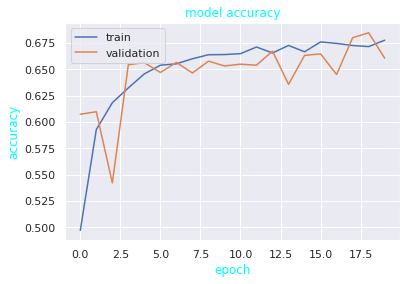

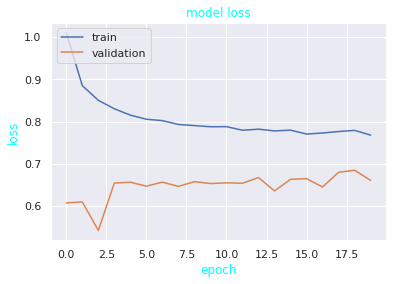


Classification Report
              precision    recall  f1-score   support

  graduation       0.70      0.54      0.61      1413
     meeting       0.67      0.59      0.63      1410
      picnic       0.61      0.83      0.70      1385

    accuracy                           0.65      4208
   macro avg       0.66      0.65      0.65      4208
weighted avg       0.66      0.65      0.65      4208


Confusion Matrix
[[ 764  262  387]
 [ 237  827  346]
 [  95  144 1146]]

Heatmap



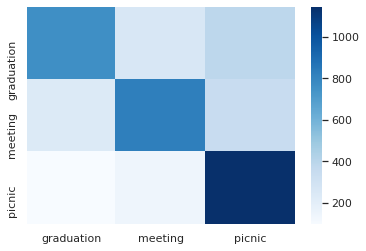

In [ ]:
# gráfico de acurácia por época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy', color='cyan')
plt.ylabel('accuracy', color='cyan')
plt.xlabel('epoch', color='cyan')
plt.legend(['train','validation'],loc='upper left')
plt.show()

# gráfico de loss por época
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss', color='cyan')
plt.ylabel('loss', color='cyan')
plt.xlabel('epoch', color='cyan')
plt.legend(['train','validation'],loc='upper left')
plt.show()

# Matriz de Confusão e relatório de classificação
print("\nClassification Report")
print(report)


print("\nConfusion Matrix")
print(matrix)
print("\nHeatmap\n")

sns.heatmap(matrix, cmap="Blues", xticklabels=class_names, yticklabels=class_names)

